In [1]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
import re
import requests
import random
from tqdm import tqdm
from datetime import datetime
import os
from os import listdir
import glob
import pickle #for saving data
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

In [2]:
def create_links_table(base_link = 'https://www.funda.nl/en/koop/heel-nederland/p', sleep_time = 3):

    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.managed_default_content_settings.images": 2} # this is to not load images
    chrome_options.add_experimental_option("prefs", prefs)

    #start a driver
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)
    driver.get(base_link + '1/')
    time.sleep(sleep_time)

    one_page_source = BeautifulSoup(driver.page_source, 'html.parser')

    try:
        pagination_list = one_page_source.find_all('div', {'class': 'pagination-pages'})
        pagination_list_a = pagination_list[0].find_all('a')
        
        pagination_list_a_len = len(pagination_list_a)
        paginattion_list_a_text = pagination_list_a[pagination_list_a_len-1].text
        
        #replace string
        paginattion_list_a_text = paginattion_list_a_text.replace(',', '')
        paginattion_list_a_text = paginattion_list_a_text.replace('.', '')
        
        #extract only numbers from the text
        paginattion_list_a_text_num = re.findall(r'\d+', paginattion_list_a_text)
        print('last page: ', paginattion_list_a_text_num[0])
        paginattion_list_a_text_num = int(paginattion_list_a_text_num[0])
    except:
        paginattion_list_a_text_num = 1
        

    links_table = pd.DataFrame(columns = ['link'])

    for i in range(1, paginattion_list_a_text_num + 1):
        one_link =  base_link+ str(i) + '/'
        links_table = links_table.append({'link': one_link}, ignore_index = True)
    
    driver.close()

    return(links_table)

In [3]:
base_link_table_all = create_links_table()



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


last page:  2338


In [6]:
base_link_table_all

,link
0,https://www.funda.nl/en/koop/heel-nederland/p1/
1,https://www.funda.nl/en/koop/heel-nederland/p2/
2,https://www.funda.nl/en/koop/heel-nederland/p3/
3,https://www.funda.nl/en/koop/heel-nederland/p4/
4,https://www.funda.nl/en/koop/heel-nederland/p5/
...,...
2326,https://www.funda.nl/en/koop/heel-nederland/p2...
2327,https://www.funda.nl/en/koop/heel-nederland/p2...
2328,https://www.funda.nl/en/koop/heel-nederland/p2...
2329,https://www.funda.nl/en/koop/heel-nederland/p2...


In [36]:
rotterdam_link_table_all = create_links_table(base_link = 'https://www.funda.nl/en/koop/rotterdam/p', sleep_time = 3)



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-4-a4df54b192eb>:8: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)


last page:  83


In [4]:
def get_links_one_page(one_link_page = 'https://www.funda.nl/en/koop/heel-nederland/p1/', sleep_time = 1):
    
    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.managed_default_content_settings.images": 2} # this is to not load images
    chrome_options.add_experimental_option("prefs", prefs)

    #start a driver
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)
    driver.get(one_link_page)
    time.sleep(sleep_time)

    one_page_source = BeautifulSoup(driver.page_source, 'html.parser')
    
    search_result_containers = one_page_source.find_all('div', {'class': 'search-result-content-inner'})
    
    links_one_page = []

    i = 1

    try:
        for search_result_container in search_result_containers:
            resultlist = search_result_container.find_all('a', {'data-object-url-tracking': 'resultlist'})
            resultlist_link = resultlist[0]['href']
            links_one_page.append(resultlist_link)
            i = i + 1
    except:
        pass

    driver.close()

    return(links_one_page)

In [5]:
def get_links_multiple_page(base_link_list = base_link_table_all['link'][:3], sleep_time_per_page = 1, save_to_csv = True):

    df = pd.DataFrame()

    for link in tqdm(base_link_list):

        links_one_page = get_links_one_page(one_link_page = link, sleep_time = sleep_time_per_page)

        #create a dataframe with a column
        df_links = pd.DataFrame(links_one_page, columns = ['ad_link'])
        df_links['page_link'] = link #via this we can see which make and model the links belong to
        #datetime string
        now = datetime.now() 
        datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))
        df_links['link_download_date_time'] = datetime_string

        #save the dataframe if save_to_csv is True
        if save_to_csv:
            #check if folder exists and if not create it
            if not os.path.exists('data/ad_links'):
                os.makedirs('data/ad_links')

            df_links.to_csv(str('data/ad_links/links_on_one_page_df' + datetime_string + '.csv'), index = False)

        df = pd.concat([df, df_links], ignore_index=True)
    
     #drop duplicates
    df = df.drop_duplicates()

    return(df)


In [6]:
def get_buy_data(base_link = 'https://www.funda.nl/en/koop/rotterdam/p', sleep_time = 2, save_to_csv = True, max_len = 10):

    base_table = create_links_table(base_link = base_link, sleep_time = 3)

    # check if max_len is integer
    if isinstance(max_len, int):
        ads_link_data = get_links_multiple_page(base_link_list = base_table[:max_len], save_to_csv=save_to_csv)
    elif max_len == 'all':
        ads_link_data = get_links_multiple_page(base_link_list = base_table, save_to_csv=save_to_csv)
    else:
        ads_link_data = "max_len is not an integer or 'all'"

    return(ads_link_data)   
    

In [7]:
#rotterdam_link_data = get_buy_data(max_len = 'all')

In [8]:
#rotterdam_link_data

# Combine files in one folder

In [9]:
def find_csv_filenames(path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

In [10]:
# concatenate the dataframes in one folder to get one file (with different columns)
def concatenate_dfs(indir = "data/ad_links", filename_to_save = 'ad_links', save_to_csv = True,  save_to_pickle = True, keep_only_latest = True, keep_only_latest_date_column = 'link_download_date_time'):
    

    fileList = find_csv_filenames(path_to_dir = indir)
    print("Found this many CSVs: ", len(fileList), " In this folder: ", str(os.getcwd()) + "/" + str(indir))

    # add string to every element in the fileList
    fileList = [indir + "/" + filename for filename in fileList]

    output_file = pd.concat([pd.read_csv(filename) for filename in fileList], ignore_index=True)

    if keep_only_latest:
        output_file_latest = output_file.groupby(['ad_link'], dropna=False).agg(number_of_ads=('ad_link', 'count'), latest_scrape=(keep_only_latest_date_column, 'max'))
        output_file_latest = output_file_latest.reset_index()
        
        output_file = pd.merge(output_file, output_file_latest[['ad_link', 'latest_scrape']], how = 'left', left_on = ['ad_link'], right_on = ['ad_link'])
        output_file = output_file.reset_index(drop=True)
        # keep rows where download_date_time is equal to latest_scrape
        output_file = output_file[output_file[keep_only_latest_date_column] == output_file['latest_scrape']]
        output_file = output_file.reset_index(drop=True)
        # drop the latest_scrape column
        output_file = output_file.drop(columns = ['latest_scrape'])

    if save_to_csv:
        output_file.to_csv("data/" + filename_to_save + ".csv", index=False)

    if save_to_pickle:
        output_file.to_pickle("data/" + filename_to_save + ".pkl")

    return(output_file)

In [11]:
all_files = concatenate_dfs(indir = "data/ad_links", save_to_csv = True, filename_to_save = 'ad_links', save_to_pickle = True, keep_only_latest=True)

Found this many CSVs:  178  In this folder:  c:\Users\menyh\Documents\funda/data/ad_links


In [12]:
all_files

,ad_link,page_link,link_download_date_time
0,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p14/,20220124_234542
1,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p15/,20220124_234551
2,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p16/,20220124_234606
3,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p21/,20220124_234702
4,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p21/,20220124_234702
...,...,...,...
1283,https://www.funda.nl/en/koop/rotterdam/huis-87...,https://www.funda.nl/en/koop/rotterdam/p83/,20220126_211034
1284,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p83/,20220126_211034
1285,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p83/,20220126_211034
1286,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p84/,20220126_211040


In [13]:
all_files.columns

Index(['ad_link', 'page_link', 'link_download_date_time'], dtype='object')

In [14]:
all_files['ad_link'][0]

'https://www.funda.nl/en/koop/rotterdam/appartement-42536788-schepenstraat-38-c/?navigateSource=resultlist'

# Scrape each ad_link

## Scrape a link for get data from it

In [15]:
def get_data_for_one_link(ad_link, sleep_time = 3):

    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.managed_default_content_settings.images": 2} # this is to not load images
    chrome_options.add_experimental_option("prefs", prefs)

    #start a driver
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)
    driver.get(ad_link)
    time.sleep(sleep_time)

    one_page_source = BeautifulSoup(driver.page_source, 'html.parser')

    driver.quit()

    #create a dataframe
    df_1 = pd.DataFrame()
    df_2 = pd.DataFrame()

    header_title_list = []
    header_subtitle_list = []

    ad_columnname_list = []
    ad_value_list = []
    
    try:
        header_title = one_page_source.find('span', {'class': 'object-header__title'})
        header_title_list.append(header_title.text)
    except:
        header_title_list.append(np.nan)

    try:
        header_subtitle = one_page_source.find('span', {'class': re.compile('^object-header__subtitle')})
        #replace /n with nothing
        header_subtitle_text = header_subtitle.text.replace('\n', '')
        header_subtitle_list.append(header_subtitle_text)
    except:
        header_subtitle_list.append(np.nan)

    try:
        list_of_objects_broad = one_page_source.find('div', {'class': 'object-kenmerken-body'})

        list_of_objects_dt = list_of_objects_broad.find_all('dt')
        i = 0
        for dt in list_of_objects_dt:
            i = i + 1
            ad_columnname_list.append(dt.text.replace('\n', ''))

        list_of_objects_dd = list_of_objects_broad.find_all('dd')
        i = 0
        for dd in list_of_objects_dd:
            i = i + 1
            ad_value_list.append(dd.text.replace('\n', ''))

        #exceptions:
        try:
            area_position = ad_columnname_list.index("Areas")
            del ad_value_list[area_position]
        except:
            pass

        try:
            cadastral_position = ad_value_list.index("Cadastral map")
            del ad_value_list[cadastral_position]
            del ad_columnname_list[cadastral_position]
            del ad_value_list[cadastral_position]
        except:
            pass

        ad_columnname_list.append('error')
        ad_value_list.append('no')

    except:
        ad_columnname_list.append('error')
        ad_value_list.append('yes')



    # add header_title to dataframe
    
    df_1['header_title'] = header_title_list
    df_1['header_subtitle'] = header_subtitle_list
    df_1['ad_link'] = ad_link
     
    #datetime string
    now = datetime.now() 
    datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))
    df_1['ad_download_date_time'] = datetime_string

    ad_columnname_list.append("ad_link")
    ad_value_list.append(ad_link)

    df_2 = pd.DataFrame([ad_value_list], columns = ad_columnname_list)

    df_1 = df_1.reset_index(drop=True)
    df_2 = df_2.reset_index(drop=True)

    #left join df_1 and df2
    df = pd.merge(df_1, df_2, how = 'left', left_on = ['ad_link'], right_on = ['ad_link'])

    df = df.reset_index(drop=True)

    cols=pd.Series(df.columns)
    for dup in df.columns[df.columns.duplicated(keep=False)]: 
        cols[df.columns.get_loc(dup)] = ([dup + '.' + str(d_idx) if d_idx != 0 else dup for d_idx in range(df.columns.get_loc(dup).sum())])
    
    df.columns=cols
    

    return(df)


In [50]:
#data = get_data_for_one_link(ad_link = 'https://www.funda.nl/en/koop/rotterdam/huis-42548338-ben-websterstraat-16/?navigateSource=resultlist')



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-49-60c9d03b8675>:8: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)


In [16]:
#data

In [52]:
#data.columns

Index(['header_title', 'header_subtitle', 'ad_link', 'ad_download_date_time',
       'Asking price', '    Asking price per m²', 'Listed since', 'Status',
       'Acceptance', 'Kind of house', 'Building type', 'Year of construction',
       'Accessibility', 'Specific', 'Type of roof', 'Areas', 'Living area',
       'External storage space', 'Plot size', 'Volume in cubic meters',
       'Number of rooms', 'Number of bath rooms', 'Bathroom facilities',
       'Number of stories', 'Facilities', 'Energy label', 'Insulation',
       'Heating', 'Hot water', 'Area', 'Ownership situation', 'Location',
       'Garden', 'Front garden', 'Garden location', 'Shed / storage',
       'Facilities.1', 'Insulation.1', 'Type of parking facilities', 'error'],
      dtype='object')

In [17]:
# read in pickle file
ad_data_all = pd.read_pickle("data/ad_data.pkl")
ad_data_all_ad_link_list = ad_data_all['ad_link']
print(len(ad_data_all_ad_link_list))

2172


In [18]:
def get_data_for_multiple_links(ad_links = all_files['ad_link'][:10], sleep_time_per_page = 1, save_to_csv = True, check_this_list = ad_data_all_ad_link_list):

    #get list elements that are not in check_this_list but in ad_links

    links_to_scrape = set(ad_links) - set(check_this_list)
    print("scraping these many links:", len(links_to_scrape))

    df = pd.DataFrame()

    error_link = []

    for link in tqdm(links_to_scrape):           
        
        try:
            one_ad_data = get_data_for_one_link(ad_link = link, sleep_time = sleep_time_per_page)

            if save_to_csv:
                #check if folder exists and if not create it
                if not os.path.exists('data/ad_data'):
                    os.makedirs('data/ad_data')

                #datetime string
                now = datetime.now() 
                datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))

                one_ad_data.to_csv(str('data/ad_data/ad_data' + datetime_string + '.csv'), index = False)

            one_ad_data = one_ad_data.reset_index(drop=True)
            df = df.reset_index(drop=True)

            df = pd.concat([df, one_ad_data], ignore_index=True)
        
        except:
            error_link.append(link)            
            continue
    
    df = df.reset_index(drop=True)
    #drop duplicates
    df = df.drop_duplicates()

    print("got error in these links:")
    print(error_link)

    if len(error_link) > 0:
        if not os.path.exists('data/logs/error_ad_download'):
            os.makedirs('data/logs/error_ad_download')

        #datetime string
        now = datetime.now() 
        datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))

        #create pandas dataframe with error links
        error_link_df = pd.DataFrame(error_link, columns = ['error_link'])
        error_link_df.to_csv(str('data/logs/error_ad_download' + datetime_string + '.csv'), index = False)

    return(df)

In [19]:
#all_ads_data = get_data_for_multiple_links(ad_links = all_files['ad_link'], sleep_time_per_page = 1, save_to_csv = True)

In [20]:
#all_ads_data

In [21]:
#all_ads_data.shape

In [22]:
#all_ads_data.columns

In [23]:
all_ads_data = concatenate_dfs(indir = "data/ad_data", filename_to_save = 'ad_data', save_to_csv = True,  save_to_pickle = True, keep_only_latest=True, keep_only_latest_date_column='ad_download_date_time')

Found this many CSVs:  4056  In this folder:  c:\Users\menyh\Documents\funda/data/ad_data


In [24]:
all_ads_data.shape

(3817, 89)

# Scrape one page link and data at the same time

In [25]:
def scrape_instantly(base_link = 'https://www.funda.nl/en/koop/heel-nederland/p', sleep_time_for_link_table = 3, sleep_time_one_ad = 2, check_this_list = ['xyz'], shuffle = True,
                    manual_page = 'all', save_to_csv = True, save_to_pickle = True):

    pages = create_links_table(base_link = base_link, sleep_time = sleep_time_for_link_table)
    pages_link = pages['link'].to_list()

    print("got this many pages:", len(pages_link))
    print("this is approximately this many ads:", len(pages_link)*15)

    if shuffle:
        pages_link = random.sample(pages_link, len(pages_link))

    if manual_page == 'all':
        len_scrape = len(pages_link)
    else:
        len_scrape = manual_page

    print("scraping these many pages:", len_scrape)
    print("this is approximately this many ads:", len_scrape * 15)

    df = pd.DataFrame()
    error_link = []

    i = 1
    for page in tqdm(pages_link[:len_scrape]):
        
        try:
            print("Scraping page: ", i, ") ", page)
            links_on_one_page = get_links_one_page(one_link_page = page, sleep_time = 1)

            print("Found these many links on this page:", len(links_on_one_page))

            i = i + 1
            
            if len(links_on_one_page) > 0:
                for one_ad_link in tqdm(links_on_one_page):
                    
                    try:
                        #check if one_ad_link is not in check_this_list

                        if one_ad_link not in check_this_list:
                            
                            print("Scraping ad: ", one_ad_link)
                            one_ad_data = get_data_for_one_link(ad_link = one_ad_link, sleep_time = sleep_time_one_ad)
                            print("---Done---")                        

                            #datetime string
                            now = datetime.now() 
                            datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))

                            if save_to_csv:
                                #check if folder exists and if not create it
                                if not os.path.exists('data/ad_data'):
                                    os.makedirs('data/ad_data')
                            
                            one_ad_data.to_csv(str('data/ad_data/ad_data' + datetime_string + '.csv'), index = False)

                            one_ad_data = one_ad_data.reset_index(drop=True)
                            df = df.reset_index(drop=True)

                            df = pd.concat([df, one_ad_data], ignore_index=True)
                    except:
                        error_link.append(one_ad_link)
                        continue
        except:
            continue
    
    if len(error_link) > 0:
        if not os.path.exists('data/logs/error_ad_download'):
            os.makedirs('data/logs/error_ad_download')

        #datetime string
        now = datetime.now() 
        datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))

        #create pandas dataframe with error links
        error_link_df = pd.DataFrame(error_link, columns = ['error_link'])
        error_link_df.to_csv(str('data/logs/error_ad_download' + datetime_string + '.csv'), index = False)
        print("Errors were saved")

    return(df)

In [73]:
all_ads_data = concatenate_dfs(indir = "data/ad_data", filename_to_save = 'ad_data', save_to_csv = True,  save_to_pickle = True, keep_only_latest=True, keep_only_latest_date_column='ad_download_date_time')

# read in pickle file
ad_data_all = pd.read_pickle("data/ad_data.pkl")
ad_data_all_ad_link_list = ad_data_all['ad_link']
print(len(ad_data_all_ad_link_list))

Found this many CSVs:  13853  In this folder:  c:\Users\menyh\Documents\funda/data/ad_data
11440


In [66]:
%%capture

ads_from = scrape_instantly(save_to_csv = True, manual_page = 5, check_this_list=ad_data_all_ad_link_list)



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\

In [194]:
#ads_from

# Data Cleaning

In [27]:
all_ads_data.columns

Index(['header_title', 'header_subtitle', 'ad_link', 'ad_download_date_time',
       'Asking price', '    Asking price per m²', 'Listed since', 'Status',
       'Acceptance', 'Kind of house', 'Building type', 'Year of construction',
       'Accessibility', 'Specific', 'Type of roof', 'Areas', 'Living area',
       'External storage space', 'Plot size', 'Volume in cubic meters',
       'Number of rooms', 'Number of bath rooms', 'Bathroom facilities',
       'Number of stories', 'Facilities', 'Energy label', 'Insulation',
       'Heating', 'Hot water', 'Area', 'Ownership situation', 'Location',
       'Garden', 'Front garden', 'Garden location', 'Shed / storage',
       'Facilities.1', 'Insulation.1', 'Type of parking facilities', 'error',
       'VVE (Owners Association) contribution', 'Type apartment',
       'Exterior space attached to the building', 'Located at',
       'Balcony/roof garden', 'Registration with KvK', 'Annual meeting',
       'Periodic contribution', 'Reserve fund pre

In [28]:
all_ads_data.head()

,header_title,header_subtitle,ad_link,ad_download_date_time,Asking price,Asking price per m²,Listed since,Status,Acceptance,Kind of house,...,Fees.3,Location.1,Commercial property,Consulting rooms,Office space,Retail space,Area.1,Type of other property,Ownership situation.5,Ownership situation.6
0,Ben Websterstraat 16,3069 XJ Rotterdam,https://www.funda.nl/en/koop/rotterdam/huis-42...,20220125_212533,"€ 400,000 kosten koper","€ 3,279 The asking price per m² (€ 400,000)...",7 weeks,Sold under reservation,Available in consultation,"Single-family home, corner house (kwadrant won...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kees Pijlstraat 21 inc box,3077 MH Rotterdam,https://www.funda.nl/en/koop/rotterdam/huis-42...,20220125_212550,"€ 450,000 kosten koper","€ 3,020 The asking price per m² (€ 450,000)...",5 weeks,Sold under reservation,Available in consultation,"Single-family home, row house",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Laagjes 11,3076 BJ Rotterdam,https://www.funda.nl/en/koop/rotterdam/huis-88...,20220125_212558,"€ 650,000 kosten koper","€ 3,801 The asking price per m² (€ 650,000)...",5 months,Available,Available in consultation,"Single-family home, row house (official/compan...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bergweg 41 d,3037 EA Rotterdam,https://www.funda.nl/en/koop/rotterdam/apparte...,20220125_212607,"€ 525,000 kosten koper","€ 3,571 The asking price per m² (€ 525,000)...","January 24, 2022",Available,Available in consultation,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Molensingel 94,3043 KC Rotterdam,https://www.funda.nl/en/koop/rotterdam/apparte...,20220125_212616,"€ 295,000 kosten koper","€ 3,598 The asking price per m² (€ 295,000)...","January 21, 2022",Available,Available in consultation,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def clean_data(data):
    
    data['price'] = data['Asking price'].str.replace('.', '')
    data['price'] = data['price'].str.replace(',', '')
    data['price'] = data['price'].str.extract('(\d+)').astype(int, errors='ignore')

    data = data.loc[~data['price'].isna()]
    data['price'] = data['price'].astype(int)

    data['livingArea'] = data['Living area'].str.replace('.', '')
    data['livingArea'] = data['livingArea'].str.replace(',', '')
    data['livingArea'] = data['livingArea'].str.extract('(\d+)').astype(int, errors='ignore')

    data = data.loc[~data['livingArea'].isna()]
    data['livingArea'] = data['livingArea'].astype(int)

    data['sqm_price'] = data['price'] / data['livingArea']
    #round to 2 decimals
    data['sqm_price'] =  data['sqm_price'].round(0)

    #extract city from link
    data['city'] = data['ad_link'].str.split('koop/').str[-1]
    data['city'] = data['city'].str.split('/').str[0]

    data['h_type'] = data['ad_link'].str.split('koop/').str[-1]
    data['h_type'] = data['h_type'].str.split('/').str[1]

    data['h_type'] = pd.np.where(data.h_type.str.contains("appartement"), "appartement", pd.np.where(data.h_type.str.contains("huis"), "house", "unknown"))

   

    return(data)

In [68]:
data_clean = clean_data(all_ads_data)

<ipython-input-29-b3c87281fdca>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['price'] = data['Asking price'].str.replace('.', '')
<ipython-input-29-b3c87281fdca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['price'].astype(int)
<ipython-input-29-b3c87281fdca>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['livingArea'] = data['Living area'].str.replace('.', '')
<ipython-input-29-b3c87281fdca>:9: Se

In [57]:
data_clean[['Asking price', 'Living area','price', 'livingArea', 'sqm_price', 'city', 'Kind of house', 'h_type']]

,Asking price,Living area,price,livingArea,sqm_price,city,Kind of house,h_type
0,"€ 400,000 kosten koper",122 m²,400000,122,3279.0,rotterdam,"Single-family home, corner house (kwadrant won...",house
1,"€ 450,000 kosten koper",149 m²,450000,149,3020.0,rotterdam,"Single-family home, row house",house
2,"€ 650,000 kosten koper",171 m²,650000,171,3801.0,rotterdam,"Single-family home, row house (official/compan...",house
3,"€ 525,000 kosten koper",147 m²,525000,147,3571.0,rotterdam,NaN,appartement
4,"€ 295,000 kosten koper",82 m²,295000,82,3598.0,rotterdam,NaN,appartement
...,...,...,...,...,...,...,...,...
4047,"€ 285,000 kosten koper",119 m²,285000,119,2395.0,borculo,"Single-family home, row house",house
4048,"€ 465,000 kosten koper",119 m²,465000,119,3908.0,hoevelaken,"Single-family home, corner house",house
4049,"€ 480,000 kosten koper",137 m²,480000,137,3504.0,heemskerk,"Single-family home, row house",house
4050,"€ 185,000 kosten koper",83 m²,185000,83,2229.0,geleen,"Single-family home, corner house",house


<Figure size 1440x360 with 0 Axes>

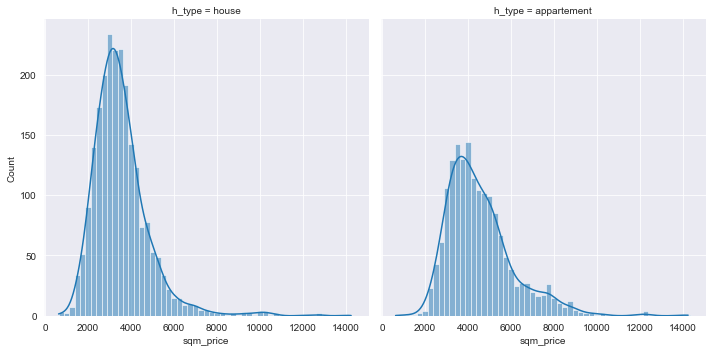

In [69]:
plt.figure(figsize=(20, 5))
sns.displot(data=data_clean[(data_clean['h_type'].isin(['house', 'appartement'])) & (data_clean['sqm_price'] < 15000)], x="sqm_price", binwidth=250, kde = True, col = 'h_type')

## Properties by city

In [70]:
count_city = data_clean.groupby(['city'], dropna=False).agg(number_of_ads=('price', 'count'), mean_price=('price', 'mean'), median_price=('price', 'median'), mean_sqm = ('livingArea', 'mean'),
                                                            mean_sqm_price = ('sqm_price', 'mean'), median_sqm_price = ('sqm_price', 'median')).reset_index()
#order by number of ads
count_city = count_city.sort_values(by=['number_of_ads'], ascending=False)
#round to 2 decimals
count_city['mean_price'] = count_city['mean_price'].round(0).astype(int)
count_city['median_price'] = count_city['median_price'].round(0).astype(int)
count_city['mean_sqm'] = count_city['mean_sqm'].round(0).astype(int)
count_city['mean_sqm_price'] = count_city['mean_sqm_price'].round(0).astype(int)
count_city['median_sqm_price'] = count_city['median_sqm_price'].round(0).astype(int)
count_city = count_city.reset_index(drop=True)
count_city[:20]

,city,number_of_ads,mean_price,median_price,mean_sqm,mean_sqm_price,median_sqm_price
0,rotterdam,1156,522726,415000,117,4355,4090
1,amsterdam,170,746411,497500,104,6827,6816
2,den-haag,108,513440,375000,112,4329,4118
3,utrecht,55,474682,450000,96,5099,5068
4,breda,41,457598,425000,117,3871,3741
5,zoetermeer,38,411066,340500,112,3564,3416
6,haarlem,32,530781,450000,97,5472,5316
7,leiden,30,498767,460000,114,4530,4312
8,hilversum,30,659217,524500,123,5117,5184
9,almere,28,386321,362500,114,3423,3290


In [72]:
count_city = data_clean.groupby(['city', 'h_type'], dropna=False).agg(number_of_ads=('price', 'count'), mean_price=('price', 'mean'), median_price=('price', 'median'), mean_sqm = ('livingArea', 'mean'),
                                                            mean_sqm_price = ('sqm_price', 'mean'), median_sqm_price = ('sqm_price', 'median')).reset_index()
#order by number of ads
count_city = count_city.sort_values(by=['number_of_ads'], ascending=False)
#round to 2 decimals
count_city['mean_price'] = count_city['mean_price'].round(0).astype(int)
count_city['median_price'] = count_city['median_price'].round(0).astype(int)
count_city['mean_sqm'] = count_city['mean_sqm'].round(0).astype(int)
count_city['mean_sqm_price'] = count_city['mean_sqm_price'].round(0).astype(int)
count_city['median_sqm_price'] = count_city['median_sqm_price'].round(0).astype(int)
count_city = count_city.reset_index(drop=True)

count_city = count_city[count_city['number_of_ads'] >= 11].sort_values(by=['median_sqm_price'], ascending=False)
count_city = count_city.reset_index(drop=True)
count_city

,city,h_type,number_of_ads,mean_price,median_price,mean_sqm,mean_sqm_price,median_sqm_price
0,amsterdam,appartement,141,678555,485000,95,6905,6954
1,amsterdam,house,29,1076328,585000,145,6447,5652
2,haarlem,appartement,15,461067,415000,83,5607,5380
3,haarlem,house,17,592294,550000,109,5353,5227
4,hilversum,house,23,755543,619000,139,5205,5189
5,utrecht,appartement,30,391450,337000,80,5148,5176
6,utrecht,house,25,574560,540000,116,5039,5068
7,leiden,appartement,13,356231,300000,81,4443,4859
8,delft,appartement,11,518227,492500,108,4733,4711
9,rotterdam,appartement,811,490715,385000,104,4533,4375


## Only Rotterdam

In [200]:
rotterdam_data = data_clean[data_clean['city'] == 'rotterdam']

<AxesSubplot:xlabel='sqm_price', ylabel='Count'>

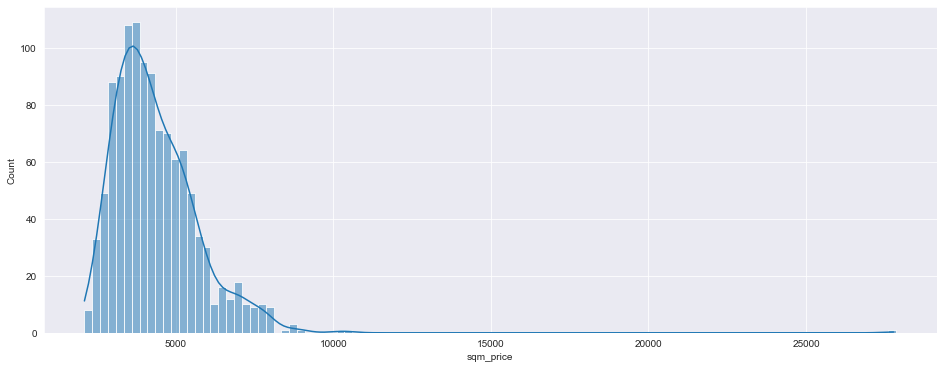

In [201]:
plt.figure(figsize=(16, 6))
sns.histplot(data=rotterdam_data, x="sqm_price", binwidth=250, kde = True)

In [117]:
inspect_data = data_clean[['header_title', 'header_subtitle', 'ad_link', 'Asking price', 'Living area','price', 'livingArea', 'sqm_price']]
inspect_data = inspect_data[inspect_data['sqm_price'] > 10000]

print(inspect_data['ad_link'].tolist())

['https://www.funda.nl/en/koop/rotterdam/huis-88871705-straatweg-127/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/huis-42680992-plasoord-27/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/appartement-88970171-boompjes-666/?navigateSource=resultlist']


<Figure size 1152x432 with 0 Axes>

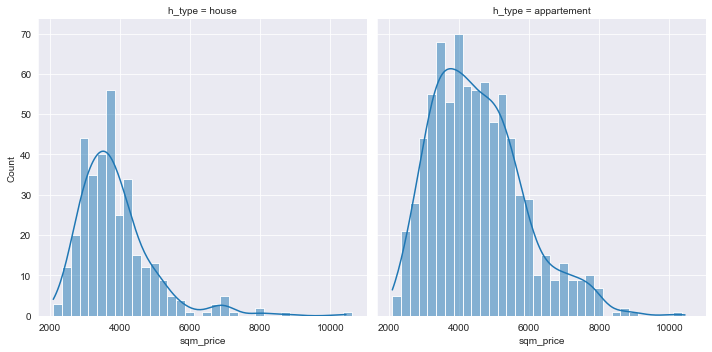

In [189]:
plt.figure(figsize=(16, 6))
sns.displot(data=rotterdam_data[(rotterdam_data['h_type'].isin(['house', 'appartement'])) & (rotterdam_data['sqm_price'] < 15000)], x="sqm_price", binwidth=250, kde = True, col = 'h_type')